In [1]:
import torch
from neurodifflogic.difflogic.compiled_model import CompiledLogicNet
from neurodifflogic.models.difflog_layers.quantize import OrderedLearnableThermometer
import torchinfo
from utils import get_training_data, get_input_data
from transforms import get_transform, get_threshold_transform
import numpy as np

/afs/hep.wisc.edu/user/ekauffma/venv/lib64/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model = torch.load("data/models/clgn-acat.pt", map_location="cpu")

In [3]:
beta = model[-1].beta
print("beta = ", beta)
tau = model[-1].tau
print("tau = ", tau)
thresholds = model[0].get_thresholds()
print("thresholds = ", thresholds)

beta =  -1792.0
tau =  8.0
thresholds =  tensor([ 1.,  3.,  6., 10., 22., 44.])


In [4]:
print(torchinfo.summary(model, input_size=(1, 1, 18, 14)))
model.train(False)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─OrderedLearnableThermometer: 1-1       [1, 6, 18, 14]            (6)
├─LogicConv2d: 1-2                       [1, 128, 14, 10]          63,488
├─Flatten: 1-3                           [1, 17920]                --
├─LogicLayer: 1-4                        [1, 8192]                 131,072
├─LogicLayer: 1-5                        [1, 4096]                 65,536
├─LogicLayer: 1-6                        [1, 2048]                 32,768
├─LogicLayer: 1-7                        [1, 4096]                 65,536
├─GroupSum: 1-8                          [1, 1]                    --
Total params: 358,406
Trainable params: 358,400
Non-trainable params: 6
Total mult-adds (M): 0.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 1.18
Estimated Total Size (MB): 1.34


Sequential(
  (0): OrderedLearnableThermometer()
  (1): LogicConv2d(
    (tree_weights): ModuleList(
      (0): ParameterList(
          (0): Parameter containing: [torch.float32 of size 128x16]
          (1): Parameter containing: [torch.float32 of size 128x16]
          (2): Parameter containing: [torch.float32 of size 128x16]
          (3): Parameter containing: [torch.float32 of size 128x16]
          (4): Parameter containing: [torch.float32 of size 128x16]
          (5): Parameter containing: [torch.float32 of size 128x16]
          (6): Parameter containing: [torch.float32 of size 128x16]
          (7): Parameter containing: [torch.float32 of size 128x16]
          (8): Parameter containing: [torch.float32 of size 128x16]
          (9): Parameter containing: [torch.float32 of size 128x16]
          (10): Parameter containing: [torch.float32 of size 128x16]
          (11): Parameter containing: [torch.float32 of size 128x16]
          (12): Parameter containing: [torch.float32 of

In [5]:
compiled_model = CompiledLogicNet(
    model=model, num_bits=1, cpu_compiler="gcc", verbose=True, 
    input_shape=(18,14), apply_thresholding=True, use_bitpacking=False
)

Found Flatten layer
Found GroupSum layer (tau=8.0, beta=-1792.0) with 1 classes
Parsed 1 thresholding, 1 conv,0 pooling, 4 linear layers
Layer execution order: [('conv', 0), ('flatten', 0), ('linear', 0), ('linear', 1), ('linear', 2), ('linear', 3)]


In [6]:
compiled_model.compile(save_lib_path="acat_work/test.so")

INCLUDE_DIR =  /tmp/tmpqzcv7w4j/include
INCLUDE_DIR =  /tmp/tmpqzcv7w4j/include
FILENAME =  /tmp/tmpqzcv7w4j/include/conv_conv_0_indices.h
Compiling finished in 151.505 seconds.


In [8]:
x_train, y_train, is_outlier_train, x_val, y_val, is_outlier_val, x_test, y_test, is_outlier_test = \
get_training_data("saved_inputs_targets", backend="torch", zb_frac=-1, use_outliers=False)
    
x_test = x_test[:1_000]
y_test = y_test[:1_000]

print(x_test.shape)

y_ZB_train.shape = (564543,)
y_outlier_train.shape = (12465,)
y_ZB_val.shape = (112909,)
y_outlier_val.shape = (2494,)
y_ZB_test.shape = (451636,)
y_outlier_test.shape = (9973,)
torch.Size([1000, 18, 14])


In [9]:
preds = model(x_test)
model.train(True)
preds_train = model(x_test)

In [10]:
preds_compiled = compiled_model(x_test.to(torch.int32))

In [11]:
print("Python = ", preds[:10])
print("C = ", preds_compiled[:10])

Python =  tensor([[ 3.3750],
        [ 1.5000],
        [ 1.7500],
        [33.1250],
        [-0.3750],
        [53.5000],
        [10.8750],
        [14.5000],
        [10.7500],
        [-2.7500]])
C =  tensor([[ 3],
        [ 1],
        [ 1],
        [33],
        [ 0],
        [53],
        [10],
        [14],
        [10],
        [-2]], dtype=torch.int32)


Text(0, 0.5, 'Counts')

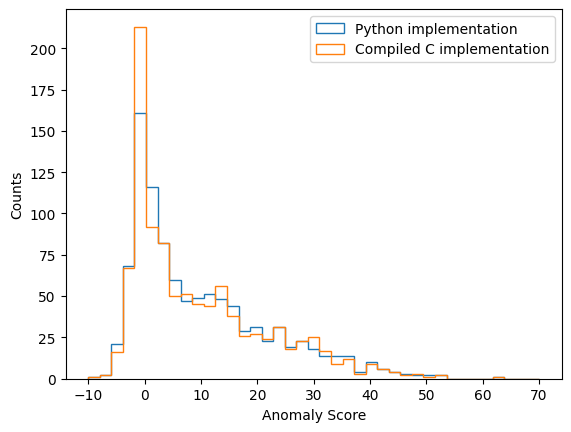

In [12]:
import matplotlib.pyplot as plt

bins=np.linspace(-10,70,40)
plt.hist(preds, bins=bins, histtype='step', label='Python implementation')
plt.hist(preds_compiled, bins=bins, histtype='step', label='Compiled C implementation')
# plt.hist(preds_train.detach().numpy(), bins=bins, histtype='step', label='Python implementation train mode')
plt.legend()
plt.xlabel('Anomaly Score')
# plt.yscale('log')
plt.ylabel('Counts')

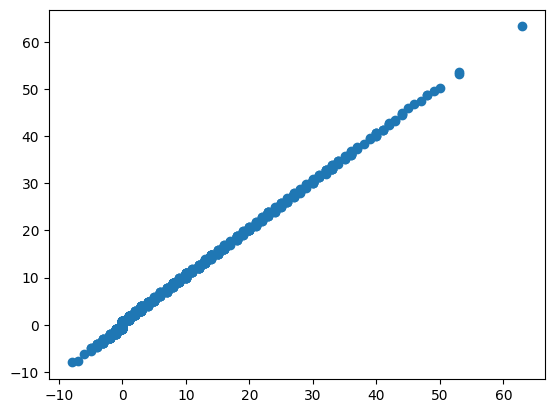

In [13]:
plt.scatter(preds_compiled, preds)

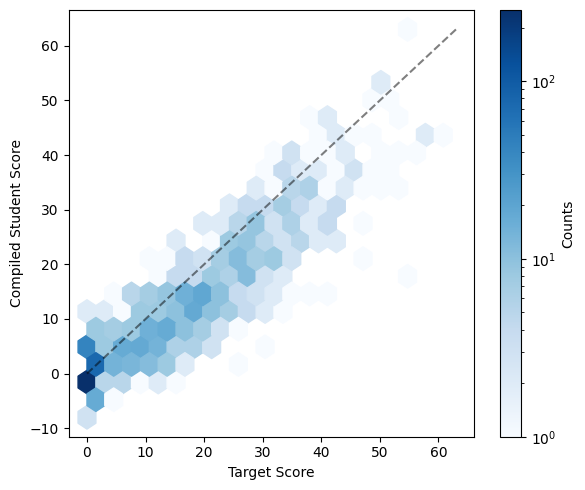

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))

# Hexbin plot
hb = ax.hexbin(
    y_test, preds_compiled,
    gridsize=20,
    cmap="Blues",
    bins="log"
)

# Colorbar
cb = fig.colorbar(hb, ax=ax)
cb.set_label("Counts")

# Axis labels
ax.set_xlabel("Target Score")
ax.set_ylabel("Compiled Student Score")

# Add y=x line
lims = [0, max(preds_compiled.max(), y_test.max())]
ax.plot(lims, lims, "k--", alpha=0.5)
# ax.set_xlim([-20,100]

plt.tight_layout()
plt.show()

In [15]:
assert np.allclose(preds.detach().numpy(), preds_compiled, atol=1), "Compiled model predictions do not match original model predictions"

In [16]:
preds

tensor([[ 3.3750],
        [ 1.5000],
        [ 1.7500],
        [33.1250],
        [-0.3750],
        [53.5000],
        [10.8750],
        [14.5000],
        [10.7500],
        [-2.7500],
        [ 9.7500],
        [12.6250],
        [19.5000],
        [16.5000],
        [13.1250],
        [16.3750],
        [-2.5000],
        [30.6250],
        [22.3750],
        [ 0.3750],
        [14.3750],
        [20.0000],
        [-1.3750],
        [ 0.7500],
        [ 4.5000],
        [35.2500],
        [27.7500],
        [11.7500],
        [10.0000],
        [13.7500],
        [37.5000],
        [12.3750],
        [-1.1250],
        [13.2500],
        [ 1.1250],
        [32.1250],
        [-3.1250],
        [10.8750],
        [31.7500],
        [-1.2500],
        [ 0.2500],
        [-1.6250],
        [ 1.2500],
        [ 4.5000],
        [-4.3750],
        [33.1250],
        [ 4.7500],
        [11.2500],
        [20.0000],
        [-0.8750],
        [14.7500],
        [ 2.6250],
        [-4.

In [17]:
with open("acatwork/y_val_ref.txt", "w") as f:
    for val in preds:
        if val>=0: f.write(f"{val.item()}\n")
        else: f.write(f"0.0\n")

In [18]:
# Open file and write each flattened entry
with open("acatwork/x_val.txt", "w") as f:
    for entry in x_test.to(torch.int32).detach().numpy():
        flat = entry.flatten()
        line = " ".join(map(str, flat))
        f.write(line + "\n")

In [7]:
model_c_code = compiled_model.get_c_code(include_dir="./acatwork/include/")
with open("acatwork/acat_model_loops.c", "w") as f:
    f.write(model_c_code)

INCLUDE_DIR =  ./acatwork/include/
INCLUDE_DIR =  ./acatwork/include/
FILENAME =  ./acatwork/include//conv_conv_0_indices.h


In [8]:
print(compiled_model.get_c_code.__qualname__)
print(compiled_model.get_c_code.__code__.co_varnames)

CompiledLogicNet.get_c_code
('self', 'include_dir', 'code_include', 'dtype', 'layer_info', 'logic_net_inp_size', 'code_helpers', 'code_logic_net', 'layer_type', 'layer_idx', 'output_shape', 'output_size', 'linear_layer_count', 'has_non_linear_layers', 'has_flatten', 'flatten_size', 'max_linear_input_size', 'i', 'layer_a', 'layer_b', 'layer_op', 'layer_output_size', 'max_linear_size', 'linear_layer_counter', 'current_shape', 'layer_name', 'conv_code', 'incl_code', 'call_code', 'current_layer_idx', 'prev_layer_info', 'prev_layer_type', 'prev_layer_idx', 'prev_shape', 'prev_size', 'is_final', 'has_non_linear', 'final_layer_type', 'final_layer_idx', '_', 'final_size', 'code')
